# **Set up Environment**
---

1. Open file on Google Colab
2. Create a shortcut on the drive from https://drive.google.com/drive/folders/1pCEBqzQDTJ3PlgdIRBY65jOugJ4xpFi6?usp=sharing
3. Edit all file paths (marked with ## CHANGE ##) to fit ur  project environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# pull git
%cd /content
# !git clone https://github.com/hmanhduc2k/CS4243-Mini-Project # version with only 800 data
!git clone https://github.com/wilfredbtan/CS4243-Mini-Project # Uncomment this to clone it once
%cd /content/CS4243-Mini-Project
!git pull
!git checkout main
!ls

/content
Cloning into 'CS4243-Mini-Project'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 33 (delta 14), reused 26 (delta 11), pack-reused 0
Unpacking objects: 100% (33/33), done.
/content/CS4243-Mini-Project
Already up to date.
error: pathspec 'main' did not match any file(s) known to git.
CS4243_MiniProject.ipynb  README.md	     test_out.pth
dataset.csv		  requirements.txt   train_label.csv
initData.sh		  splitTrainTest.sh  WeaponDetection.pth
model1.pth		  template.py
model_template.ipynb	  test_label.csv


In [3]:
!pip3 install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.1 MB/s 
     |████████████████████████████████| 7.6 MB 44.5 MB/s 
     |████████████████████████████████| 163 kB 72.7 MB/s 


In [4]:
# gets train test split
## COMMENT OUT AFTER RUNNING ONCE ##
# %%bash
# chmod +x /content/CS4243-Mini-Project/initData.sh
# /content/CS4243-Mini-Project/initData.sh
# chmod +x /content/CS4243-Mini-Project/splitTrainTest.sh
# /content/CS4243-Mini-Project/splitTrainTest.sh

Import packages:

In [5]:
from collections import defaultdict
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import torch
import torchvision
from torchvision.transforms import transforms
from torchvision import models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable

from PIL import Image
torch.manual_seed(42)

import torch.optim as optim
from torch.optim import Adam

from transformers import T5ForConditionalGeneration, AutoTokenizer, Adafactor

# **Data Visualization and Data Preparation**

---



Distribution of dataset:

In [6]:
# Split dataset into test and train

# dataset_size = len(train_dataset)
# train_size = int(0.8 * dataset_size)
# test_size = dataset_size - train_size

In [7]:
train_df = pd.read_csv("train_label.csv")
test_df = pd.read_csv("test_label.csv")
count = len(train_df)
normal_count = len(train_df[train_df["label"] == 0])
carrying_count = len(train_df[train_df["label"] == 1])
threat_count = len(train_df[train_df["label"] == 2])
print(f'TRAIN: Count: {count} - Normal: {normal_count*100/count:.2f}% - Carrying: {carrying_count*100/count:.2f}% - Threat: {threat_count*100/count:.2f}%')

count = len(test_df)
normal_count = len(test_df[test_df["label"] == 0])
carrying_count = len(test_df[test_df["label"] == 1])
threat_count = len(test_df[test_df["label"] == 2])
print(f'TEST: Count: {count} - Normal: {normal_count*100/count:.2f}% - Carrying: {carrying_count*100/count:.2f}% - Threat: {threat_count*100/count:.2f}%')

train_df.head()

TRAIN: Count: 4437 - Normal: 37.80% - Carrying: 30.90% - Threat: 31.30%
TEST: Count: 506 - Normal: 35.57% - Carrying: 32.41% - Threat: 32.02%


directory  label
0  normal/00000.42797_100.png      0
1  normal/00000.42797_200.png      0
2   normal/00000.42797_30.png      0
3  normal/00010.40911_100.png      0
4   normal/00010.40911_30.png      0

In [8]:
%cd /content/drive/My Drive/cs4243 test

/content/drive/My Drive/cs4243 test


Preparing datapaths:

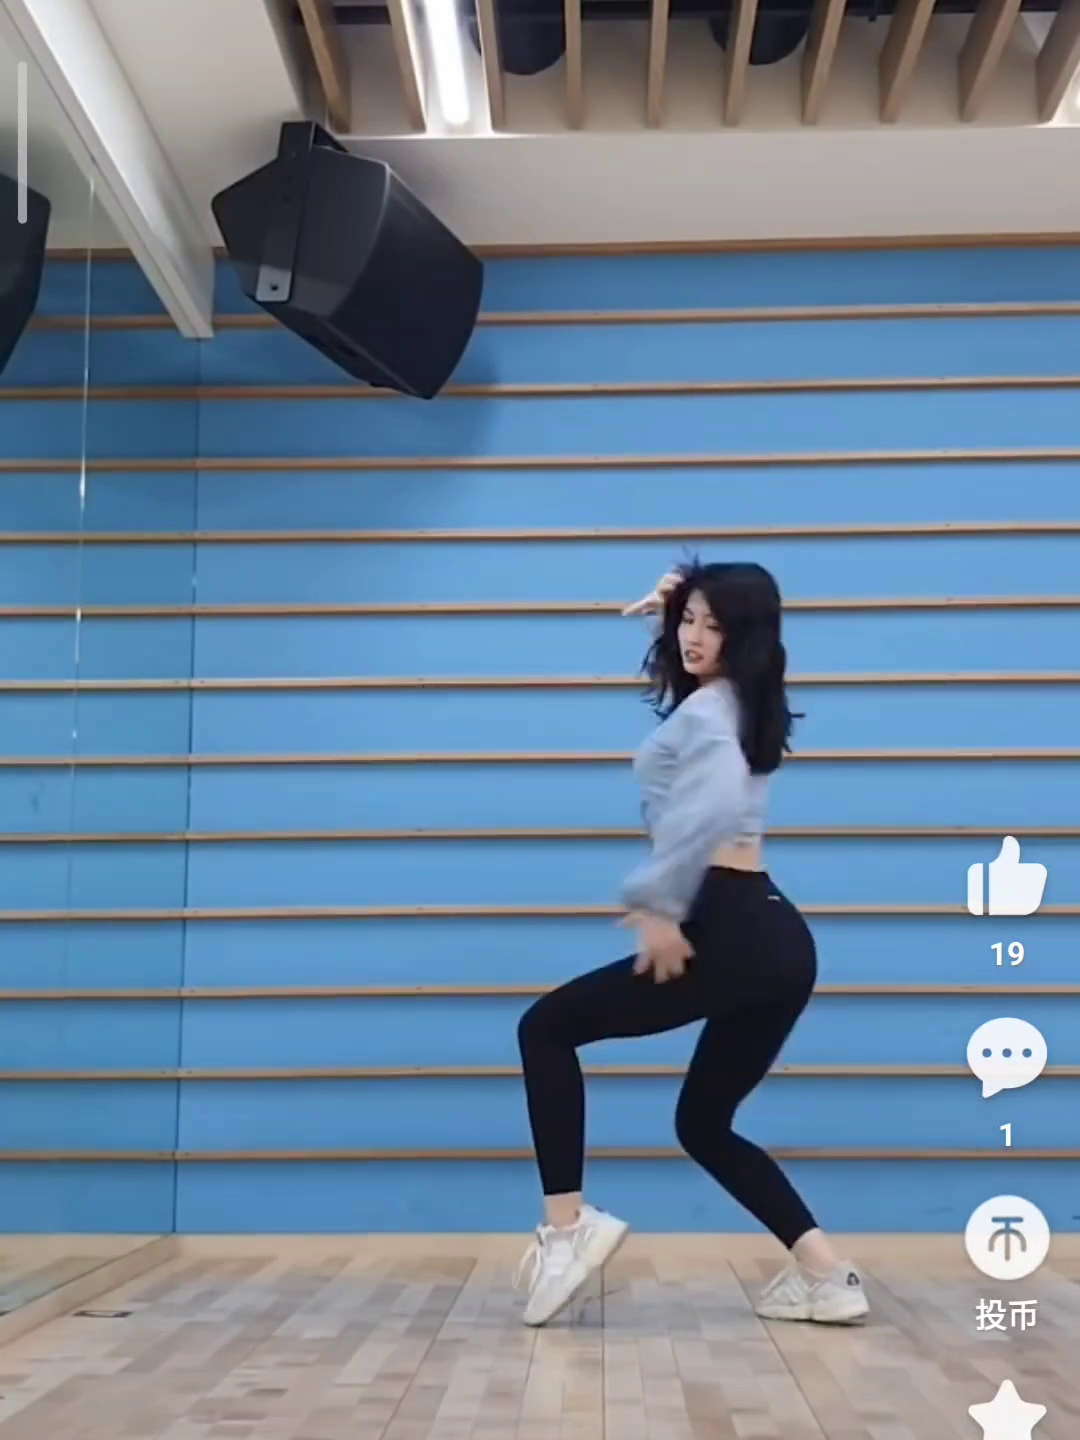

In [9]:
root = "./cs4243_smallest/" ## CHANGE ##
# root = "./cs4243_smallest/" # on local machine
img_path = train_df['directory'][0]

img = Image.open(root + str(img_path)) #similar to cv2.imread()
img

# Data Loader

---

In [10]:
class CS4243_dataset(Dataset): 
    def __init__(self, root_path , dataframe, transform=None):
        self.df = dataframe    
        self.transform = transform
        self.root_path = root_path
        
        self.image_paths = self.df['directory']
        self.labels = self.df['label']
                
    def __getitem__(self, index):
        img_path = self.image_paths[index] 
        image = Image.open(self.root_path + str(img_path))
        target = torch.tensor(self.labels[index])
      
        if self.transform != None:
            image = self.transform(image)
          
        return [image, target, img_path]
       
    def __len__(self):
        return len(self.df)

# **Neural Networks**
---

## **NETWORK 3**

In [11]:
class Network3(nn.Module):
    def __init__(self, number_of_labels, dropout=0.3):
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(3, 12, 5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(nn.Conv2d(12, 16, 5),
                                   nn.ReLU(),
                                   nn.AdaptiveMaxPool2d((5, 5))) # can also use transformer instead to standardize input size
        self.fc1 = nn.Sequential(nn.Flatten(),
                                 nn.Dropout(p=dropout),
                                 nn.Linear(16 * 5 * 5, 120),
                                 nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(120, 84),
                                 nn.ReLU())
        self.fc3 = nn.Linear(84, number_of_labels)

    def forward(self, x):
        h1 = self.conv1(x)
        h2 = self.conv2(h1)
        h3 = self.fc1(h2)
        h4 = self.fc2(h3)
        y = self.fc3(h4)
        return y

## **NETWORK 4**

In [12]:
class Network4(nn.Module):
    def __init__(self, n_channels, number_of_labels, dropout=0.3):
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(n_channels, 12, 5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2, 2))
        self.conv2 = nn.Sequential(nn.Conv2d(12, 16, 5),
                                   nn.ReLU(),
                                   nn.AdaptiveMaxPool2d((5, 5))) # can also use transformer instead to standardize input size
        self.fc1 = nn.Sequential(nn.Flatten(),
                                 nn.Dropout(p=dropout),
                                 nn.Linear(16 * 5 * 5, 120),
                                 nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(120, 84),
                                 nn.ReLU())
        self.fc3 = nn.Linear(84, number_of_labels)

    def forward(self, x):
        h1 = self.conv1(x)
        h2 = self.conv2(h1)
        h3 = self.fc1(h2)
        h4 = self.fc2(h3)
        y = self.fc3(h4)
        return y

# **Training Function**
---

In [13]:
def train(model, data_loader, loss_fn, optimizer, num_epoch, device='cpu', model_path=None):
    start = datetime.datetime.now()
    losses = []

    for epoch in range(num_epoch):  # loop over the dataset multiple times
        model.train()
        running_loss = 0.0

        for i, (images, labels, _) in enumerate(data_loader, 0):
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = loss_fn(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 10 == 9:    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
        losses.append(running_loss)

    end = datetime.datetime.now()
    print('Training finished in {} minutes.'.format((end - start).seconds / 60.0)) 
        
    if model_path != None:
        torch.save(model.state_dict(), model_path)
        print('Model saved in ', model_path)
    
    print(losses)
    return model, losses

# **Testing Function**
---

In [14]:
def test(model, data_loader, output_path, device='cpu', classes=None):
    model.eval()

    with open(output_path, 'w+') as f_output:
            with torch.no_grad():
                for (images, labels, image_paths) in data_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    # the label with the highest energy will be our prediction
                    _, predicted = torch.max(outputs.data, 1)
                    for i in range(len(images)):
                        label_i = labels[i].item()
                        predicted_i = predicted[i].item()
                        image_path_i = image_paths[i]
                        if classes != None:
                            label_i = classes[label_i]
                            predicted_i = classes[predicted_i]
                        f_output.write("{0}, {1}, {2}\n".format(label_i, predicted_i, image_path_i))

    # compute the accuracy over all test images
    print("Testing finished. Model saved in ", output_path)

In [15]:
# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Evaluate output file
def show_test_accuracy(output_path, root="", transformer=None, show=0):
    correct = defaultdict(int)
    count = defaultdict(int)
    images = []
    show_target = []
    show_predicted = []

    with open(output_path) as f:
        lines = f.read().splitlines()
        for line in lines:
            target, predicted, image_path = line.split(", ")
            count[target] += 1
            if target == predicted:
                correct[target] += 1
            if len(images) < show:
                image = Image.open(root + str(image_path))
                if transformer != None:
                    image = transformer(image)
                        
                images.append(image[:3, : ,:])
                show_target.append(target)
                show_predicted.append(predicted)
    
    total = [0, 0]
    for label in count:
        print("{0} accuracy: {1}/{2} = {3:.2f}%".format(label, correct[label], count[label], correct[label]/count[label]*100))
        total[1] += count[label]
        total[0] += correct[label]
    print("Overall accuracy: {0}/{1} = {2:.2f}%".format(total[0], total[1], total[0]/total[1]*100))
    
    if len(images) > 0:
        imageshow(torchvision.utils.make_grid(images))
        print("target: ", show_target)
        print("predicted: ", show_predicted)

In [16]:
def plotConfusionMatrix(output_path, classes):
    data = pd.read_csv(output_path, header=None, skipinitialspace=True)
    data = data.values
    target = data[:, 0]
    predicted = data[:, 1]
    cm = confusion_matrix(target, predicted, labels=classes)
    df_cm = pd.DataFrame(cm, index = [i for i in classes],
                    columns = [i for i in classes])
    plt.figure(figsize = (5, 4))
    sn.heatmap(df_cm, annot=True, fmt='g')
    plt.xlabel("Predicted")
    plt.ylabel("Target")
    plt.show()
    return cm

def generateClassificationReport(output_path, classes):
    data = pd.read_csv(output_path, header=None, skipinitialspace=True)
    data = data.values
    target = data[:, 0]
    predicted = data[:, 1]
    print(classification_report(target, predicted, target_names=classes))

def plotROC(output_path, classes):
    data = pd.read_csv(output_path, header=None, skipinitialspace=True)
    data = data.values
    target = data[:, 0]
    predicted = data[:, 1]
    target = label_binarize(target, classes=classes)
    predicted = label_binarize(predicted, classes=classes)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(target[:, i], predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(target.ravel(), predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot of a ROC curve for a specific class
    for i in range(len(classes)):
        plt.figure()
        lw = 2
        plt.plot(fpr[i], tpr[i], color='darkorange',
                lw=lw, label='ROC curve for %s (area = %0.2f)' % (classes[i], roc_auc[i]))
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc="lower right")
        plt.show()

# **Load Model Function**

In [44]:
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))

# **Evaluation**

---


Normalize data using transformers:

In [17]:
transformations = transforms.Compose([
    transforms.Resize(size=(32,32),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer:

In [18]:
batch_size = 50
classes = ('normal', 'carrying', 'threat')
num_of_labels = len(classes)

loss_fn = nn.CrossEntropyLoss
optimizer = Adam
optim_params = {'lr':0.001, 'weight_decay':0.0001}
epoch = 20
dropout = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else (
    "mps" if torch.backends.mps.is_available() else "cpu"))

### **NETWORK 3**

Using fourier transform on each RGB channel to remove noise:

In [19]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., weight=1.):
        self.std = std
        self.mean = mean
        self.weight = weight
        
    def __call__(self, tensor):
        tensor = tensor + (torch.randn(tensor.size()) * self.std + self.mean) * self.weight
        return tensor.clip(0, 1)
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

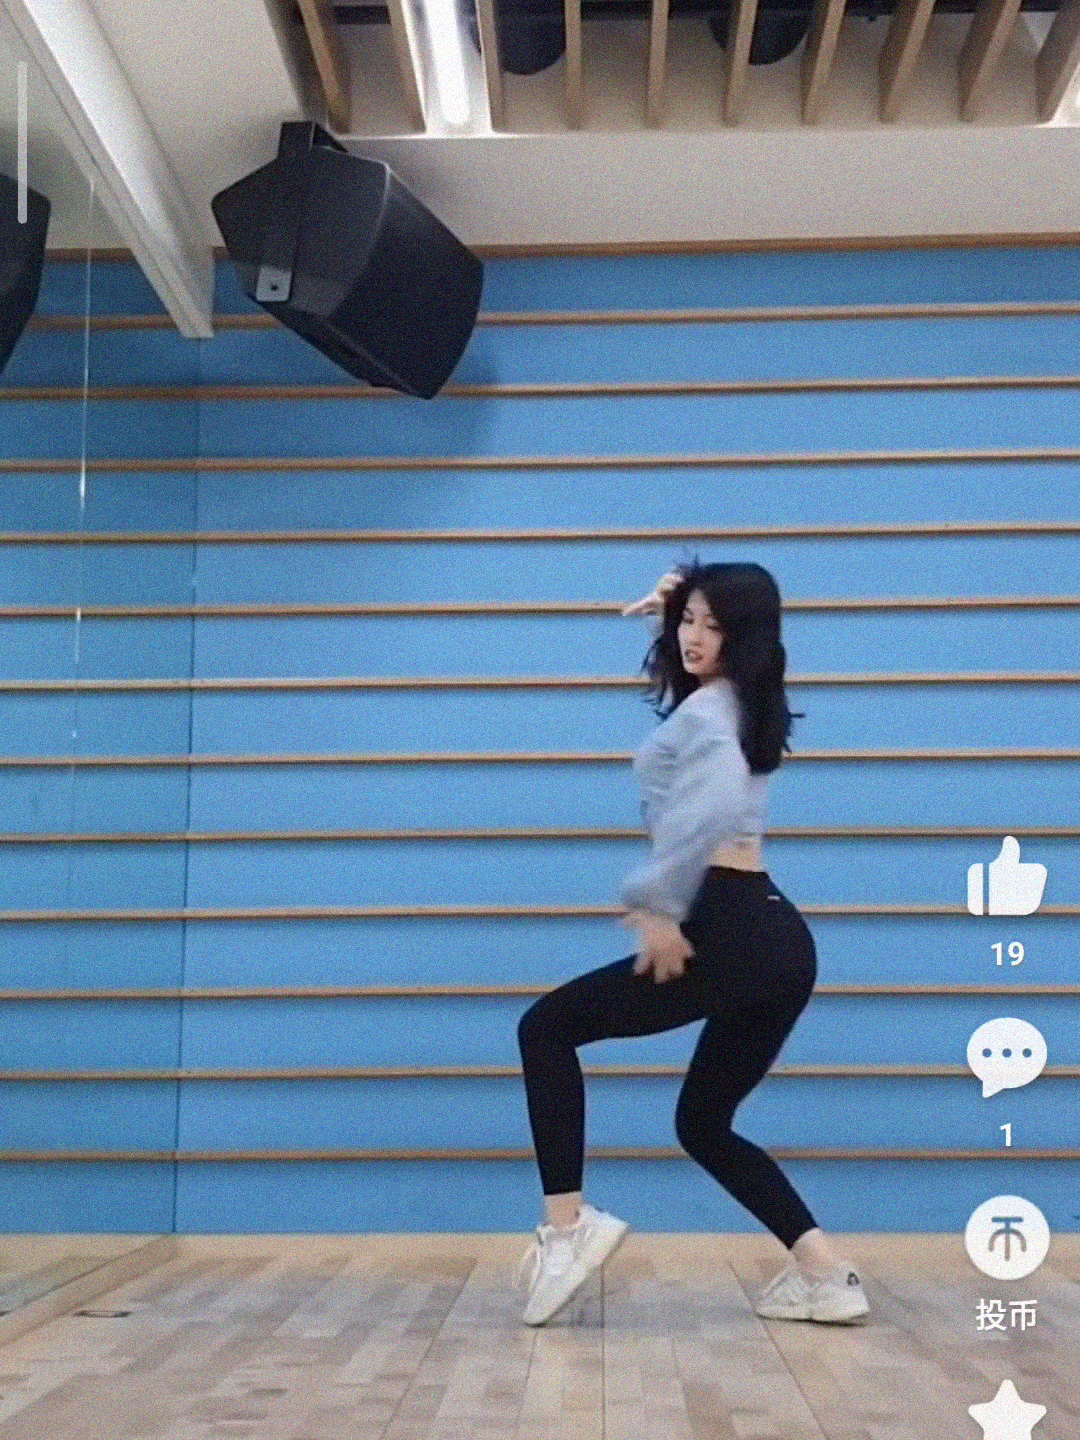

In [20]:
transform3 = transforms.Compose([
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.1, 0.5), # adding noise to see how the ft works
    transforms.ToPILImage()
])

transform3(img)

In [21]:
def gaussian_kernel(m, n, std):
    gaussian_m = signal.gaussian(m, std)
    gaussian_n = signal.gaussian(n, std)
    gaussian2D = np.outer(gaussian_m, gaussian_n)
    return torch.from_numpy(gaussian2D)

def ft_bandpass_filter(img, low=0.1, high=0.4):
    m, n = img.shape
    low = low * min(m, n)
    high = high * min(m, n)
    ft = torch.fft.fft2(img)
    ft_shift = torch.fft.fftshift(ft)
    ft_shift_abs = torch.abs(ft_shift)
    ft_shift_phase = torch.angle(ft_shift) 
    
    # filtering
    # low is the lowest frequency allowed -> bound of high-pass filter
    # high is the highest frequency allowed -> bound of low-pass filter
    low_pass_f = gaussian_kernel(m, n, high)
    if low == 0:
        high_pass_f = torch.ones_like(low_pass_f)
    else:
        high_pass_f = 1 - gaussian_kernel(m, n, low)
    band_pass_f = torch.multiply(low_pass_f, high_pass_f) 
    ft_shift_abs = torch.multiply(ft_shift_abs, band_pass_f) 
    
    # rebuild image
    z = torch.multiply (ft_shift_abs , torch.exp((1j)*(ft_shift_phase)))
    ift_shift = torch.fft.ifftshift(z)
    filt_img = torch.fft.ifft2(ift_shift)
    filt_img = torch.abs(filt_img).clip(0, 1)
        
    return filt_img

def f3_ft(img):
    red_channel = ft_bandpass_filter(img[0, :, :], low=0, high=0.2)
    green_channel = ft_bandpass_filter(img[1, :, :], low=0, high=0.2)
    blue_channel = ft_bandpass_filter(img[2, :, :], low=0, high=0.2)
    return torch.stack([red_channel,
                       green_channel, 
                       blue_channel]).float()

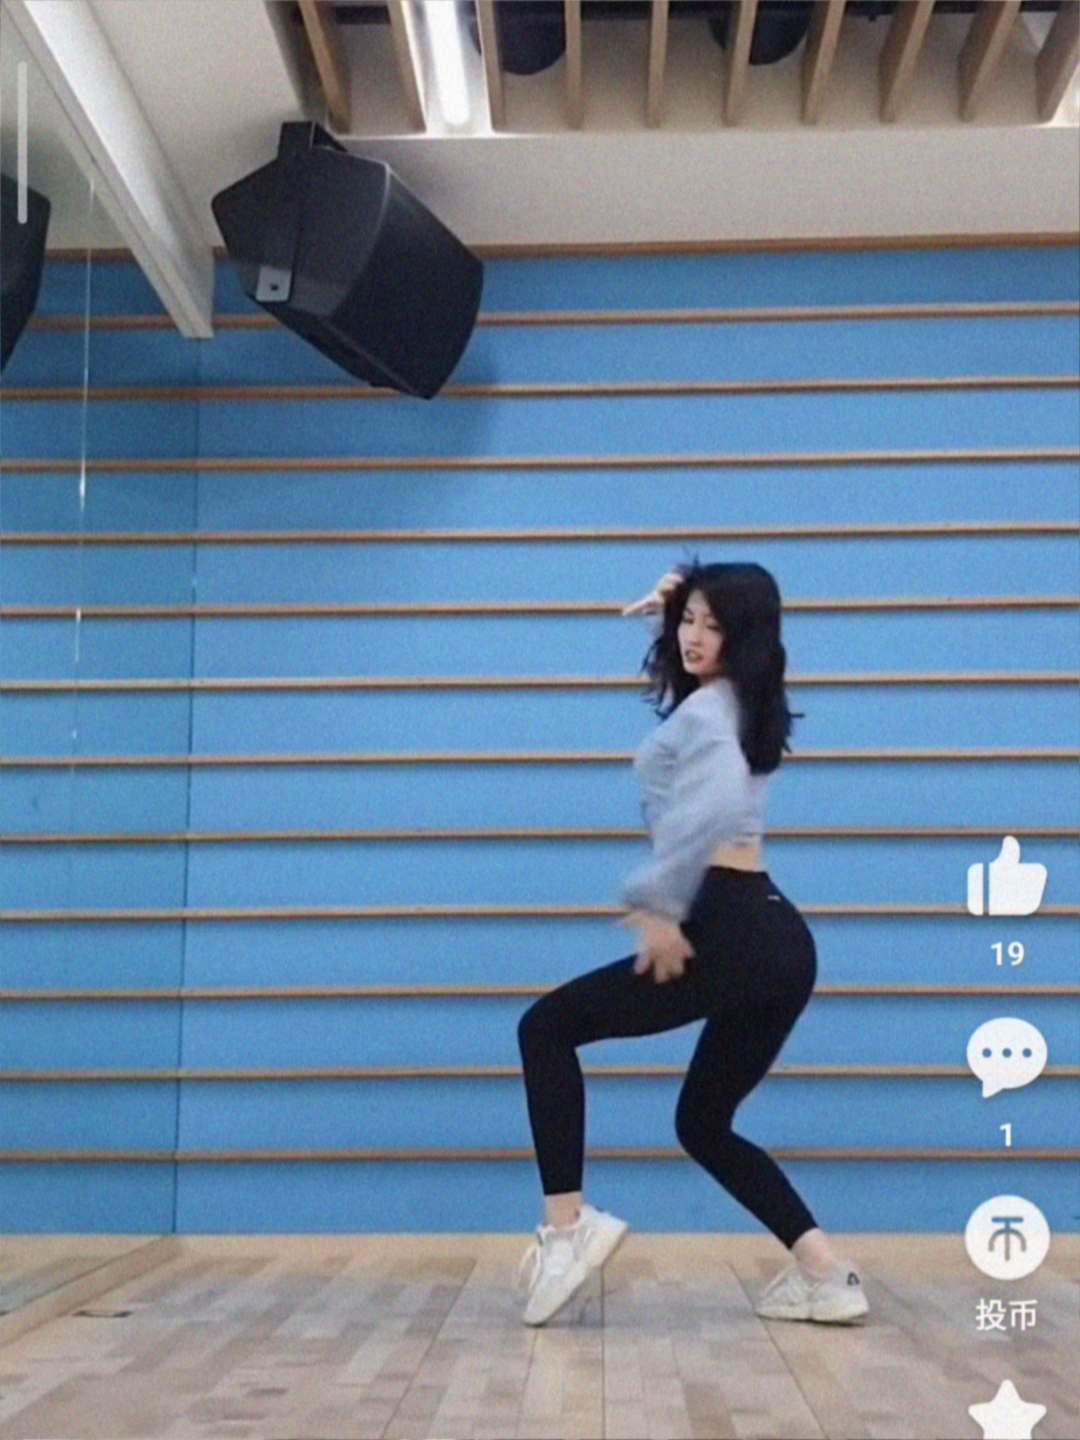

In [22]:
transform3 = transforms.Compose([
    # transforms.Resize(size=(32,32),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.1, 0.5), # adding noise to see how the ft works
    transforms.Lambda(f3_ft),
    # transforms.Normalize((0.5, 0.5, 0.5), 
    #                      (0.5, 0.5, 0.5)),
    transforms.ToPILImage()
])

transform3(img)

**TRAINING**

In [23]:
# normalize data using transformers
transform3 = transforms.Compose([
    transforms.Resize(size=(32,32),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Lambda(f3_ft),
    transforms.Normalize((0.5, 0.5, 0.5), 
                         (0.5, 0.5, 0.5)),
])

# train
train_set3 = CS4243_dataset(root, train_df, transform = transform3)
train_loader3 = DataLoader(train_set3, batch_size=batch_size, shuffle = True, drop_last=True)
print("The number of images in a training set is: ", len(train_loader3)*batch_size)

# test
test_set3 = CS4243_dataset(root, test_df, transform=transform3)
test_loader3 = DataLoader(test_set3, batch_size=batch_size, shuffle=False, drop_last=True)
print("The number of images in a test set is: ", len(test_loader3)*batch_size)

print("The number of batches per epoch is: ", len(train_loader3))

The number of images in a training set is:  4400
The number of images in a test set is:  500
The number of batches per epoch is:  88


In [24]:
model3_path = "./model3.pth" ## CHANGE ##
output3_path = "./test_out3.pth" ## CHANGE ##

[1,    10] loss: 0.110
[1,    20] loss: 0.110
[1,    30] loss: 0.109
[1,    40] loss: 0.107
[1,    50] loss: 0.109
[1,    60] loss: 0.109
[1,    70] loss: 0.108
[1,    80] loss: 0.107
[2,    10] loss: 0.109
[2,    20] loss: 0.105
[2,    30] loss: 0.107
[2,    40] loss: 0.105
[2,    50] loss: 0.107
[2,    60] loss: 0.107
[2,    70] loss: 0.105
[2,    80] loss: 0.105
[3,    10] loss: 0.103
[3,    20] loss: 0.102
[3,    30] loss: 0.103
[3,    40] loss: 0.101
[3,    50] loss: 0.098
[3,    60] loss: 0.101
[3,    70] loss: 0.104
[3,    80] loss: 0.099
[4,    10] loss: 0.098
[4,    20] loss: 0.098
[4,    30] loss: 0.098
[4,    40] loss: 0.098
[4,    50] loss: 0.096
[4,    60] loss: 0.094
[4,    70] loss: 0.100
[4,    80] loss: 0.098
[5,    10] loss: 0.092
[5,    20] loss: 0.090
[5,    30] loss: 0.093
[5,    40] loss: 0.091
[5,    50] loss: 0.094
[5,    60] loss: 0.093
[5,    70] loss: 0.091
[5,    80] loss: 0.090
[6,    10] loss: 0.086
[6,    20] loss: 0.093
[6,    30] loss: 0.088
[6,    40] 

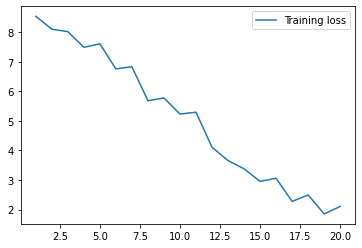

In [25]:
model3 = Network3(num_of_labels, dropout).to(device)
_, losses3 = train(model3, train_loader3, loss_fn(), 
                   optimizer(model3.parameters(), **optim_params), epoch, device, model3_path)
plt.plot(list(range(1, epoch + 1)), losses3, label='Training loss')
plt.legend()
plt.show()

Testing finished. Model saved in  ./test_out3.pth
normal accuracy: 135/180 = 75.00%
carrying accuracy: 107/164 = 65.24%
threat accuracy: 104/156 = 66.67%
Overall accuracy: 346/500 = 69.20%


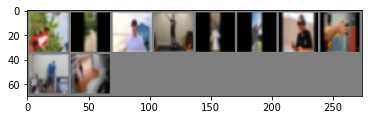

target:  ['normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal']
predicted:  ['threat', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'threat', 'normal', 'normal']


In [40]:
test(model3, test_loader3, output3_path, device, classes)
show_test_accuracy(output3_path, root, transform3, show=10)

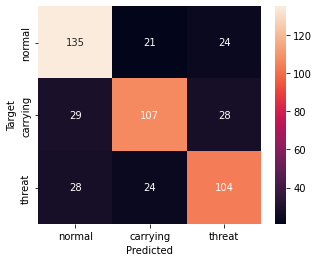

In [41]:
cm3 = plotConfusionMatrix(output3_path, classes)

In [42]:
generateClassificationReport(output3_path, classes)

              precision    recall  f1-score   support

      normal       0.70      0.65      0.68       164
    carrying       0.70      0.75      0.73       180
      threat       0.67      0.67      0.67       156

    accuracy                           0.69       500
   macro avg       0.69      0.69      0.69       500
weighted avg       0.69      0.69      0.69       500



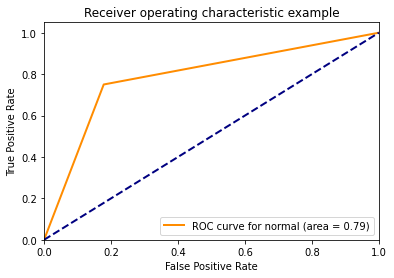

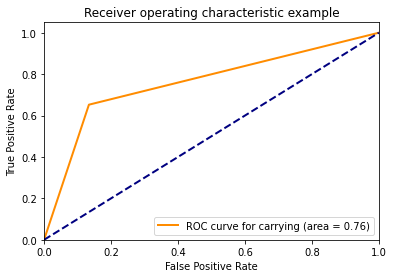

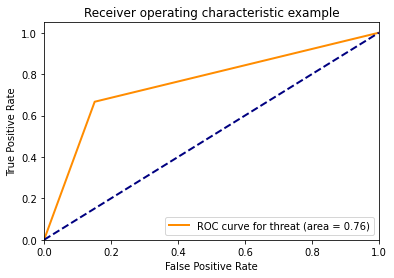

In [43]:
plotROC(output3_path, classes)

## **NETWORK 4**

In [30]:
def gaussian_kernel(m, n, std):
    gaussian_m = signal.gaussian(m, std)
    gaussian_n = signal.gaussian(n, std)
    gaussian2D = np.outer(gaussian_m, gaussian_n)
    return torch.from_numpy(gaussian2D)

def ft_bandpass_filter(img, low=0.1, high=0.4):
    m, n = img.shape
    low = low * min(m, n)
    high = high * min(m, n)
    ft = torch.fft.fft2(img)
    ft_shift = torch.fft.fftshift(ft)
    ft_shift_abs = torch.abs(ft_shift)
    ft_shift_phase = torch.angle(ft_shift) 
    
    # filtering
    # low is the lowest frequency allowed -> bound of high-pass filter
    # high is the highest frequency allowed -> bound of low-pass filter
    low_pass_f = gaussian_kernel(m, n, high)
    if low == 0:
        high_pass_f = torch.ones_like(low_pass_f)
    else:
        high_pass_f = 1 - gaussian_kernel(m, n, low)
    band_pass_f = torch.multiply(low_pass_f, high_pass_f) 
    ft_shift_abs = torch.multiply(ft_shift_abs, band_pass_f) 
    
    # rebuild image
    z = torch.multiply (ft_shift_abs , torch.exp((1j)*(ft_shift_phase)))
    ift_shift = torch.fft.ifftshift(z)
    filt_img = torch.fft.ifft2(ift_shift)
    filt_img = torch.abs(filt_img).clip(0, 1)
        
    return filt_img

In [31]:
def f4(img):
    channels = []
    bands = [0, 0.2, 0.5, 0.8, 1]
    for i in range(1, len(bands)):
        channels.append(ft_bandpass_filter(img[0, :, :], low=bands[i-1], high=bands[i]))
        channels.append(ft_bandpass_filter(img[1, :, :], low=bands[i-1], high=bands[i]))
        channels.append(ft_bandpass_filter(img[2, :, :], low=bands[i-1], high=bands[i]))
    
    return torch.stack(channels).float()

In [32]:
# normalize data using transformers
transform4 = transforms.Compose([
    transforms.Resize(size=(32,32),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Lambda(f4),
    transforms.Normalize((0.5, ) * 12, 
                         (0.5, ) * 12),
])

# train
train_set4 = CS4243_dataset(root, train_df, transform=transform4)
train_loader4 = DataLoader(train_set4, batch_size=batch_size, shuffle=True, drop_last=True)
print("The number of images in a training set is: ", len(train_loader4)*batch_size)

# test
test_set4 = CS4243_dataset(root, test_df, transform=transform4)
test_loader4 = DataLoader(test_set4, batch_size=batch_size, shuffle=False, drop_last=True)
print("The number of images in a test set is: ", len(test_loader4)*batch_size)

print("The number of batches per epoch is: ", len(train_loader4))

The number of images in a training set is:  4400
The number of images in a test set is:  500
The number of batches per epoch is:  88


In [33]:
model4_path = "./model4.pth" ## CHANGE ##
output4_path = "./test_out4.pth" ## CHANGE ##

[1,    10] loss: 0.110
[1,    20] loss: 0.110
[1,    30] loss: 0.109
[1,    40] loss: 0.110
[1,    50] loss: 0.110
[1,    60] loss: 0.109
[1,    70] loss: 0.109
[1,    80] loss: 0.109
[2,    10] loss: 0.109
[2,    20] loss: 0.109
[2,    30] loss: 0.108
[2,    40] loss: 0.109
[2,    50] loss: 0.110
[2,    60] loss: 0.110
[2,    70] loss: 0.109
[2,    80] loss: 0.109
[3,    10] loss: 0.109
[3,    20] loss: 0.108
[3,    30] loss: 0.107
[3,    40] loss: 0.111
[3,    50] loss: 0.109
[3,    60] loss: 0.109
[3,    70] loss: 0.108
[3,    80] loss: 0.107
[4,    10] loss: 0.106
[4,    20] loss: 0.108
[4,    30] loss: 0.106
[4,    40] loss: 0.109
[4,    50] loss: 0.107
[4,    60] loss: 0.108
[4,    70] loss: 0.106
[4,    80] loss: 0.104
[5,    10] loss: 0.106
[5,    20] loss: 0.103
[5,    30] loss: 0.104
[5,    40] loss: 0.104
[5,    50] loss: 0.103
[5,    60] loss: 0.102
[5,    70] loss: 0.106
[5,    80] loss: 0.100
[6,    10] loss: 0.100
[6,    20] loss: 0.100
[6,    30] loss: 0.100
[6,    40] 

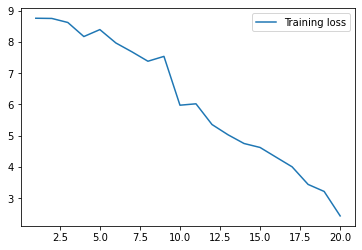

In [34]:
model4 = Network4(12, num_of_labels, dropout).to(device)
_, losses4 = train(model4, train_loader4, loss_fn(), 
                   optimizer(model4.parameters(), **optim_params), epoch, device, model4_path)
plt.plot(list(range(1, epoch + 1)), losses4, label='Training loss')
plt.legend()
plt.show()

Testing finished. Model saved in  ./test_out4.pth
normal accuracy: 123/180 = 68.33%
carrying accuracy: 92/164 = 56.10%
threat accuracy: 109/156 = 69.87%
Overall accuracy: 324/500 = 64.80%


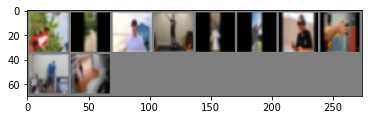

target:  ['normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal']
predicted:  ['carrying', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'threat', 'normal', 'normal']


In [35]:
test(model4, test_loader4, output4_path, device, classes)
show_test_accuracy(output4_path, root, transform4, show=10)

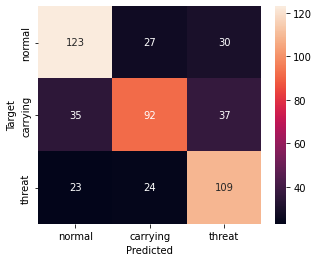

In [36]:
cm4 = plotConfusionMatrix(output4_path, classes)

In [37]:
generateClassificationReport(output4_path, classes)

              precision    recall  f1-score   support

      normal       0.64      0.56      0.60       164
    carrying       0.68      0.68      0.68       180
      threat       0.62      0.70      0.66       156

    accuracy                           0.65       500
   macro avg       0.65      0.65      0.65       500
weighted avg       0.65      0.65      0.65       500



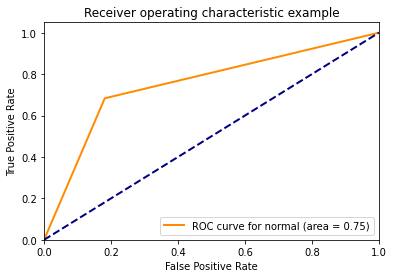

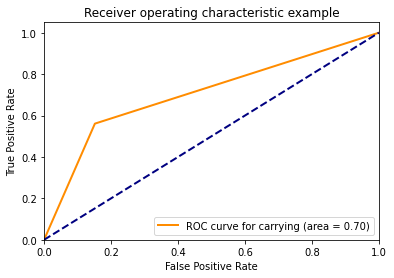

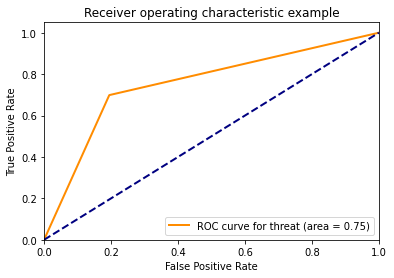

In [38]:
plotROC(output4_path, classes)